# mag2exp: Torque magnetometry

This notebook is designed to go with the ______ paper and showcase the code and the techniques that `mag2exp` included in the paper.

In [1]:
%config InlineBackend.figure_formats = ['svg']

Import packages

In [2]:
import discretisedfield as df
import micromagneticmodel as mm
import oommfc as oc
import numpy as np
from tqdm import tqdm
import mag2exp
import micromagneticdata as mmd
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('default')

Define the energy terms of the micromagnetic simulation.

In [3]:
system = mm.System(name="Torque_simulation")

H_max = 3/mm.consts.mu0 # 3 T
angle = 1 *np.pi/180  # Missalign the applied field by 1 degree to break symmtry.
system.energy = (mm.Exchange(A=1.6e-11)
                 + mm.DMI(D=4e-3, crystalclass='T')
                 + mm.UniaxialAnisotropy(K=5.1e5, u=(0, 0, 1))
                 + mm.Demag()
                 + mm.Zeeman(H=(0, H_max*np.sin(angle), H_max*np.cos(angle))))
system.energy

Exchange(A=1.6e-11) + DMI(D=0.004, crystalclass='T') + UniaxialAnisotropy(K=510000.0, u=(0, 0, 1)) + Demag() + Zeeman(H=(0, 41664.551300137275, 2386960.5453476724))

Define the initial magnetisation.

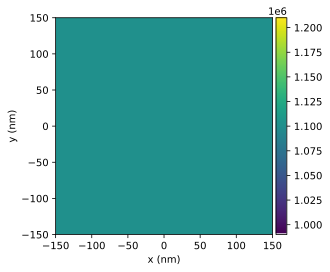

In [4]:
Ms = 1.1e6  # A/m
region = df.Region(p1=(-150e-9, -150e-9, -20e-9), p2=(150e-9, 150e-9, 0))
mesh = df.Mesh(region=region, cell=(5e-9, 5e-9, 5e-9))
system.m = df.Field(mesh, dim=3, value=(0, 0, 1), norm=Ms)
system.m.plane('z').z.mpl()

Minimise the energy

Running OOMMF (ExeOOMMFRunner)[2022/07/15 08:59]... (0.4 s)


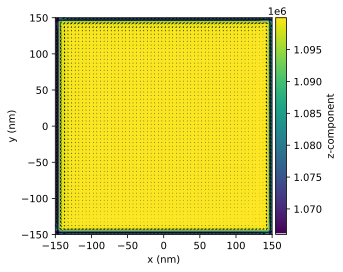

In [5]:
md = oc.MinDriver()
md.drive(system)

# Plot relaxed configuration: vectors in z-plane
system.m.plane('z').mpl()

Short functions to plot the torque.

In [6]:
plt.style.use('default')
matplotlib.rcParams.update({'font.size': 15})
def plot_torque():
    fig, ax = plt.subplots(figsize=(7,5))
    ax.grid(zorder=0)
    ax.scatter(angles, [i[0] for i in torque_arr], zorder=1)
    ax.scatter(np.array(angles[52]), np.array(torque_arr)[52,0], marker='D', c='k', zorder=2)
    ax.hlines(system.energy.uniaxialanisotropy.K, xmin=np.min(angles), xmax=np.max(angles), color='r', zorder=3)
    ax.hlines(-system.energy.uniaxialanisotropy.K, xmin=np.min(angles), xmax=np.max(angles), color='r', zorder=3)

    ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi])
    ax.set_xticklabels(['0',r'$\pi/2$',r'$\pi$',r'$3\pi/2$', r'$2\pi$'])
    ax.set_yticks([-4e5, -2e5, 0, 2e5, 4e5])
    ax.set_yticklabels([r'$-4 \times 10 ^{5}$', r'$-2 \times 10 ^{5}$', '0', r'$2 \times 10 ^{5}$', r'$4 \times 10 ^{5}$'])
    ax.set_xlabel("Angle (rad.)")
    ax.set_ylabel(r"Torque (Nm$^{-2}$)")
    ax.set_xlim([0, 2*np.pi])
    ax.text(-0.25, system.energy.uniaxialanisotropy.K*0.96, r'$K$')
    ax.text(-0.45, -system.energy.uniaxialanisotropy.K*1.04, r'$-K$')
    plt.show()

def plot_magnetisation(H):
    fig, ax = plt.subplots(figsize=(6,7))
    idx = 52
    angle = angles[52]
    sweep_data = mmd.Data(system.name)
    sweep_data[idx].m0.orientation.plane('z').z.mpl.scalar(ax=ax, cmap='plasma', colorbar_label=r'$M_z$ (Ms)', interpolation='spline16',)
    sweep_data[idx].m0.orientation.plane('z', n=(20,20)).mpl.vector(ax=ax, use_color=False, scale=20, headwidth=6, width=0.004)
    ax.set_title(f'Applied field\n (0,{H_max*np.sin(angle)*mm.consts.mu0:.2f},{H_max*np.cos(angle)*mm.consts.mu0:.2f}) T')
    fig.tight_layout()
    plt.show()

Define the range of angles measured.

In [7]:
angles = np.linspace(0, 2*np.pi, 2*71)

Calculate the torque curve.

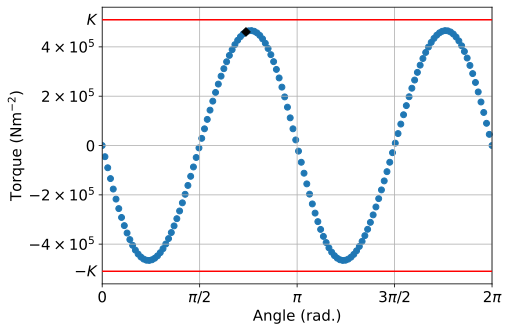

In [8]:
torque_arr = []
for angle in angles:
    H = (0, H_max*np.sin(angle), H_max*np.cos(angle))
    system.energy.zeeman.H = H
    md.drive(system, verbose=0)
    torque_arr.append(mag2exp.magnetometry.torque(system.m, H))

plot_torque()  # Use matplotlib to plot

Plot a snapshot of the magnetisation

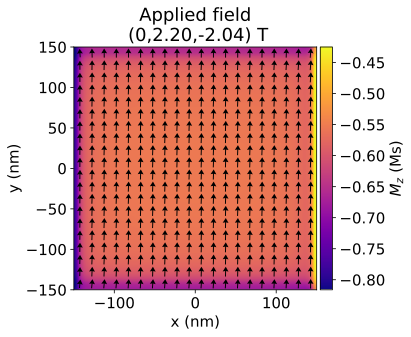

In [9]:
plot_magnetisation((0.0, 2.20, -2.04))